In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

from tensorflow.keras.datasets import mnist

from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Reshape

In [2]:
def call_data():
    (train_images, train_labels), (test_images, test_labels) = mnist.load_data()

    print(f"Train images shape : {train_images.shape}")
    print(f"Shape of single image : {train_images[0].shape}")

    train_images = train_images.astype('float32') / 255.0
    test_images = test_images.astype('float32') / 255.0

    data = pd.DataFrame({
        "labels" : train_labels, 'imgs' : train_images.tolist()
    })

    return data

In [3]:
df = call_data()

Train images shape : (60000, 28, 28)
Shape of single image : (28, 28)


In [4]:
print('Max number of images is' , max(df['labels'].value_counts()), 'for label : ', df['labels'].value_counts().idxmax())
print('Min number of images is' , min(df['labels'].value_counts()), 'for label : ', df['labels'].value_counts().idxmin())

Max number of images is 6742 for label :  1
Min number of images is 5421 for label :  5


### Data Format For Model

**Input**
- The input data is a list of images, each image is a 2D array of shape (28, 28).
- The output data is a image.
- All images are in a mathematical format.
- Each image is one larger than the previous one and one smaller than the next.

| Inputs         | Output |
|:--------------:|:------:|
| 0 - 1 - 2 - 3  |   4    |
| 1 - 2 - 3 - 4  |   5    |
| 2 - 3 - 4 - 5  |   6    |
| 3 - 4 - 5 - 6  |   7    |
| 4 - 5 - 6 - 7  |   8    |
| 5 - 6 - 7 - 8  |   9    |


### Examples

![formula_sample1](./outputs/formula_sample_1.png)
![formula_sample2](./outputs/formula_sample_2.png)

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

class DataGenerator:
    def __init__(self, img_df):
        self.new_df = pd.DataFrame(columns=['input1', 'input2', 'input3', 'input4', 'output'])
        self.img_df = img_df

    @staticmethod
    def filter_by_label(df, label):
        return df[df['labels'] == label]['imgs']

    def generate_data_for_labels(self, df, label_numbers):
        min_label_count = min(df[df['labels'].isin(label_numbers)]['labels'].value_counts())
        for i in range(min_label_count):
            self.new_df.loc[len(self.new_df)] = [
                self.filter_by_label(df, label_numbers[0]).iloc[i],
                self.filter_by_label(df, label_numbers[1]).iloc[i],
                self.filter_by_label(df, label_numbers[2]).iloc[i],
                self.filter_by_label(df, label_numbers[3]).iloc[i],
                self.filter_by_label(df, label_numbers[4]).iloc[i]
            ]
        return self.new_df

    @staticmethod
    def generate_formula_data(n):
        return n, (n + 1), (n + 2), (n + 3), (n + 4)

    def generate_data(self):
        data_formats = [list(self.generate_formula_data(i)) for i in range(6)]
        for data_format in data_formats:
            self.generate_data_for_labels(self.img_df, data_format)

        return self.new_df

    def re_scale_data(self): 
        generated_df = self.generate_data() 

        X = np.stack([np.array(generated_df[col].tolist()) for col in ['input1', 'input2', 'input3', 'input4']], axis=-1)
        y = np.stack([np.array(generated_df[col].tolist()) for col in ['output']], axis=-1)

        X = X.reshape(-1, 28, 28, 4)
        y = y.reshape(-1, 28, 28, 1)

        X = np.transpose(X, (0, 3, 1, 2))
        y = np.transpose(y, (0, 3, 1, 2))

        X = X.reshape((X.shape[0]), 4, 28*28)

        y = y.reshape((y.shape[0]), 28, 28)

        return X, y

    def train_test_split_data(self): 
        X, y = self.re_scale_data() 
        return train_test_split(X, y, test_size=0.2, random_state=23)


In [7]:
generator = DataGenerator(df)

X_train, X_test, y_train, y_test = generator.train_test_split_data()

In [19]:
print("X_train shape : {}".format(X_train.shape))
print("y_train shape : {}".format(y_train.shape))

X_train shape : (26357, 4, 784)
y_train shape : (26357, 28, 28)


In [8]:
def generator_model(optimizer):
    model = Sequential()

    model.add(LSTM(128, activation='relu', input_shape=(4, 28*28), return_sequences=True))
    model.add(LSTM(64, activation='relu'))

    model.add(Dense((28*28), activation='linear'))
    model.add(Reshape((28, 28)))

    model.compile(
        optimizer=optimizer, loss='mean_squared_error', metrics='mse'
    )
    model.fit(X_train, y_train, epochs=1)

    return model

In [9]:
model = generator_model('adam')

824/824 [==============================] - 27s 26ms/step - loss: 0.0576 - mse: 0.0576


In [10]:
model.save("./model/imggenerator_adam.h5")

In [11]:
def img_generator(n):
    test_images = X_test[n : n+5]

    generated_image = model.predict(test_images)
    plt.figure(figsize=(14, 4))

    for i in range(4):
        plt.subplot(1, 5, i + 1)
        
        plt.imshow(test_images[0, i].reshape((28, 28)), cmap='gray')
        plt.axis('off')

    plt.subplot(1, 5, 5)
    plt.title('Generated Image')
    plt.imshow(generated_image[0], cmap='gray')
    plt.axis('off')

    plt.show()

1/1 [==============================] - 0s 35ms/step


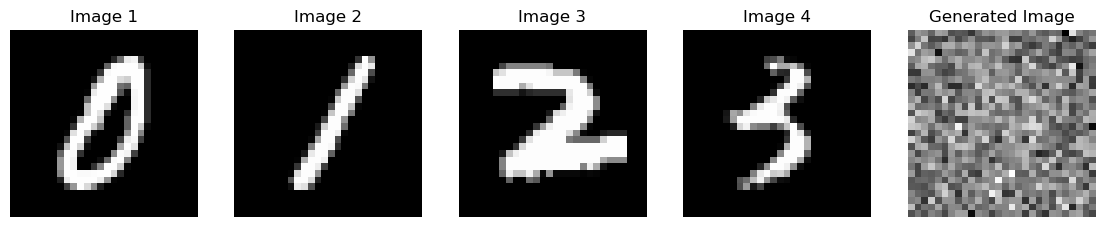

1/1 [==============================] - 0s 44ms/step


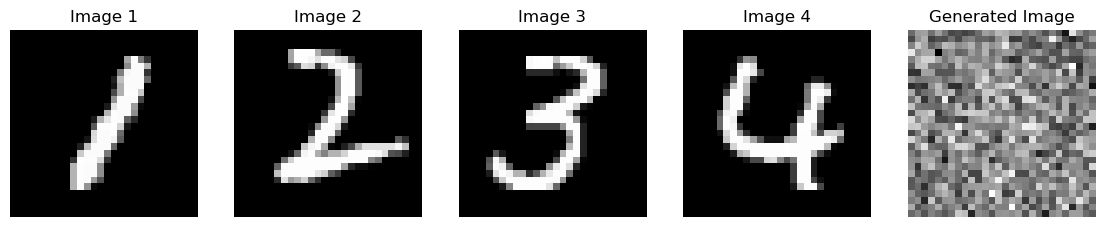

1/1 [==============================] - 0s 47ms/step


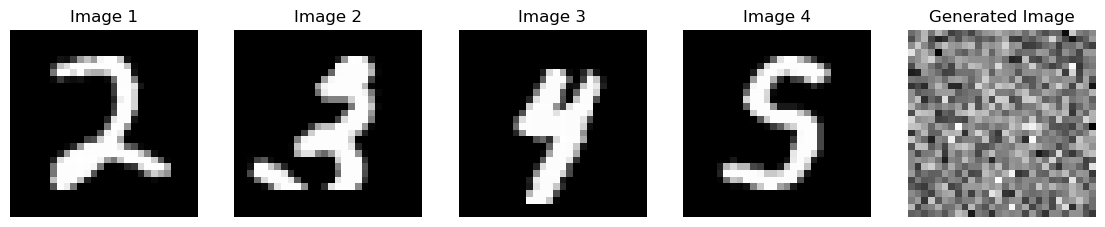

1/1 [==============================] - 0s 43ms/step


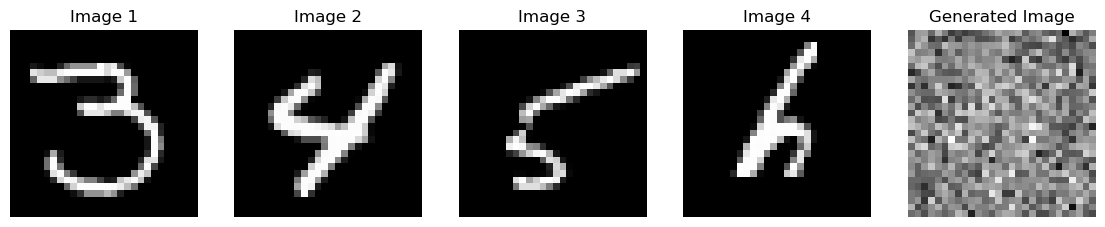

1/1 [==============================] - 0s 39ms/step


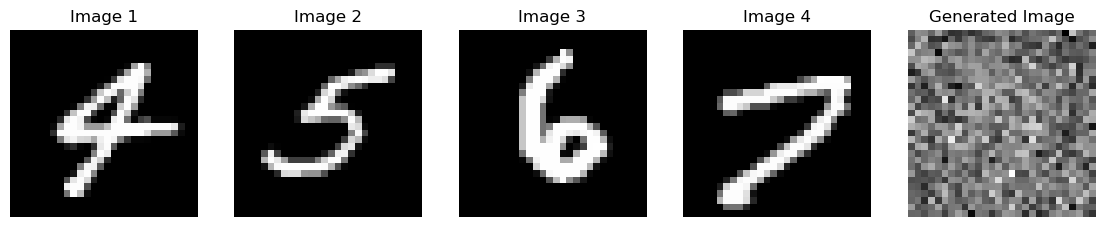

1/1 [==============================] - 0s 40ms/step


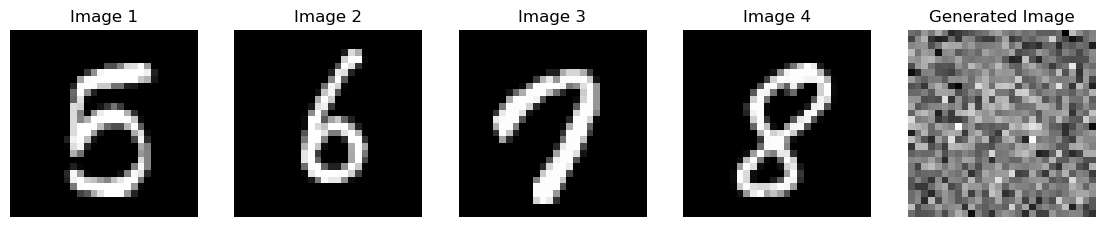

In [54]:
# optimizer = SGD(Stochastic Gradient Descent)

for i in [0, 3, 30, 117, 125, 12]:
    img_generator(i)

1/1 [==============================] - 1s 506ms/step


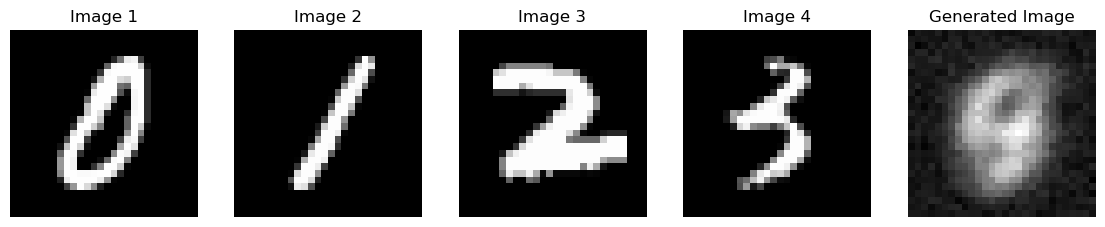

1/1 [==============================] - 0s 42ms/step


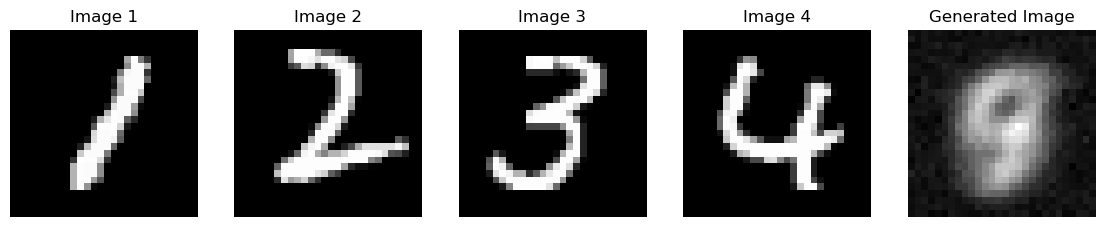

1/1 [==============================] - 0s 44ms/step


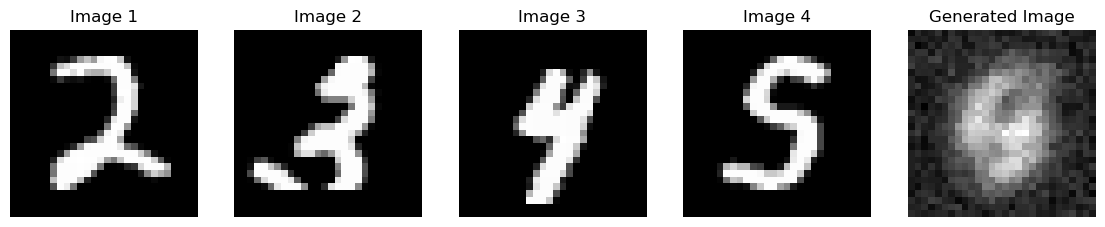

1/1 [==============================] - 0s 55ms/step


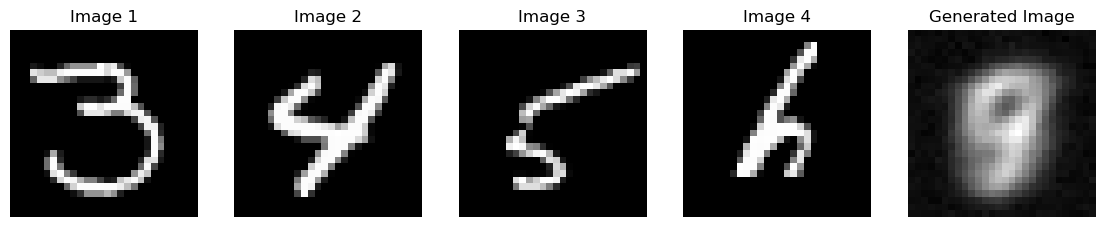

1/1 [==============================] - 0s 44ms/step


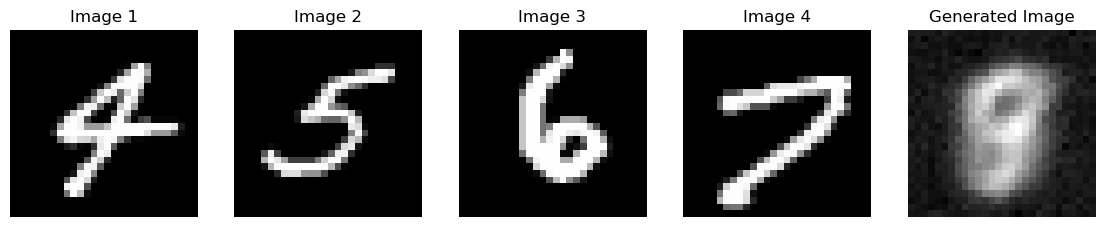

1/1 [==============================] - 0s 39ms/step


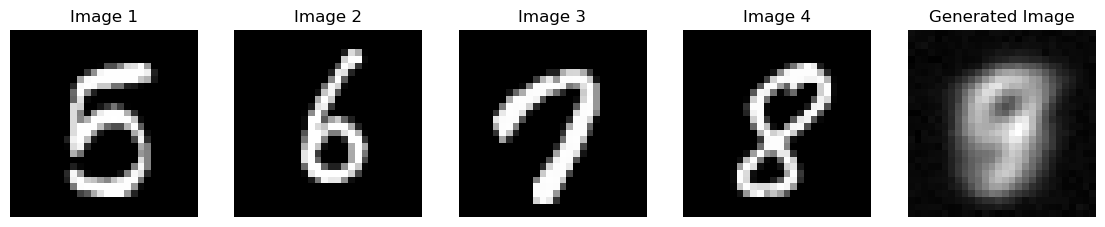

In [60]:
# optimizer = RMSPROP(Root Mean Squared Propagation)

for i in [0, 3, 30, 117, 125, 12]:
    img_generator(i)

1/1 [==============================] - 1s 623ms/step


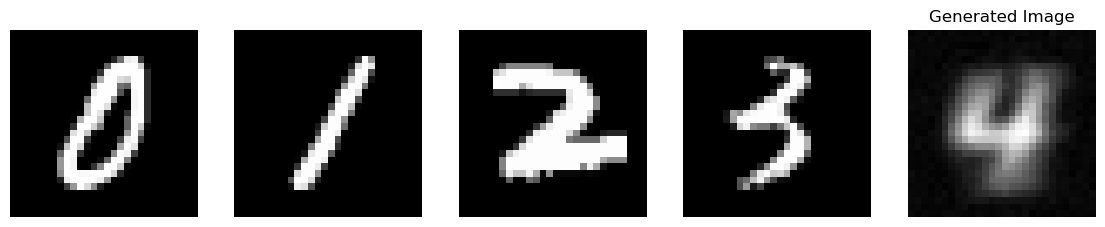

1/1 [==============================] - 0s 37ms/step


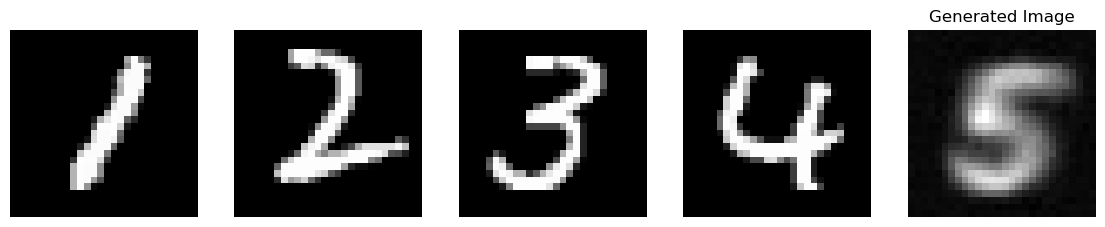

1/1 [==============================] - 0s 46ms/step


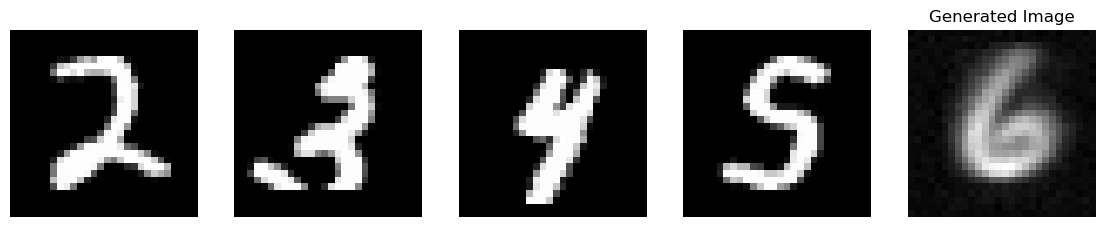

1/1 [==============================] - 0s 40ms/step


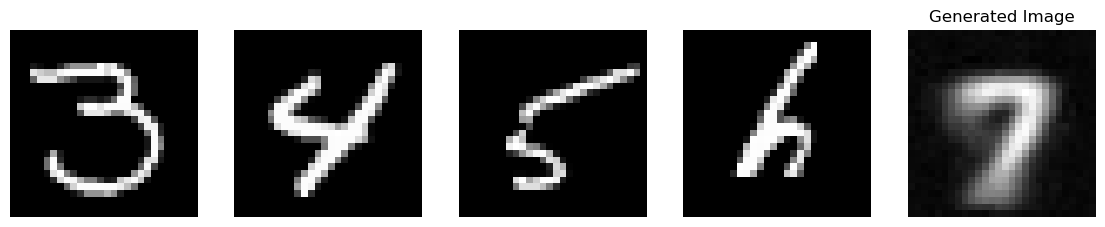

1/1 [==============================] - 0s 42ms/step


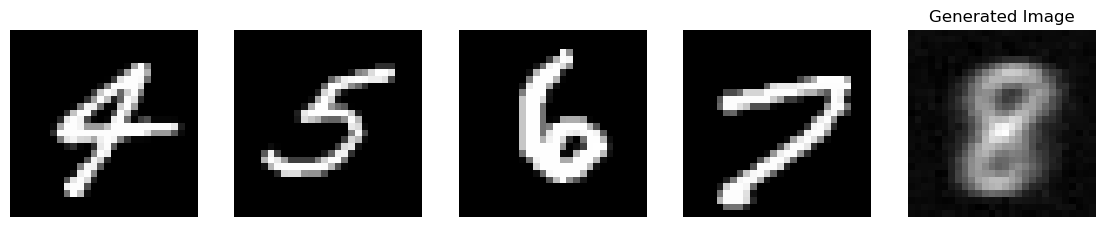

1/1 [==============================] - 0s 39ms/step


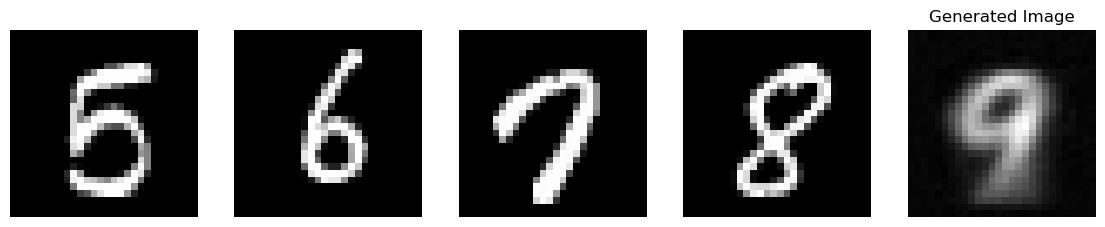

In [12]:
# optimizer = Adam

for i in [0, 3, 30, 117, 125, 12]:
    img_generator(i)